**Jupyter notebook for test of any type**

In [1]:
import sys
import os
import pandas as pd
from datasets import load_dataset
import os
import numpy as np
import pyspark as ps
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, asc, min, max, to_timestamp, col, count, date_trunc, udf, pandas_udf, PandasUDFType,to_date, date_trunc,length,lower, split, explode
import langdetect 
from pyspark.sql.types import StringType, BooleanType
import matplotlib.pyplot as plt

# Get the absolute path of the project root
project_root = os.path.abspath("..")  # Adjust if necessary

# Add the src directory to Python's path
sys.path.append(os.path.join(project_root, "src"))

if project_root not in sys.path:
    sys.path.append(project_root)


/home/pipe/venv/bigDatavenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from data import s3_utils as s3U

In [3]:
!wget https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main/Stock_news/All_external.csv

--2025-03-24 17:31:43--  https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main/Stock_news/All_external.csv
Resolving huggingface.co (huggingface.co)... 54.192.95.70, 54.192.95.21, 54.192.95.79, ...
Connecting to huggingface.co (huggingface.co)|54.192.95.70|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/a0/19/a01967ba742831f4b6903f146b4f5d9a3d2eeeefa619387e8cc87df2d889332c/5d4c018036bd82ca821da71b7a9c0c7db3289642e0fc6f897ea69f4a0c5135c3?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27All_external.csv%3B+filename%3D%22All_external.csv%22%3B&response-content-type=text%2Fcsv&Expires=1742837503&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MjgzNzUwM319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2EwLzE5L2EwMTk2N2JhNzQyODMxZjRiNjkwM2YxNDZiNGY1ZDlhM2QyZWVlZWZhNjE5Mzg3ZThjYzg3ZGYyZDg4OTMzMmMvNWQ0YzAxODAzNmJkODJjYTgyMWRhNzFiN2E5YzBjN2RiMzI4OTY0MmUwZ

In [3]:
bucket= "financialdata-sa"
news_external = "RawNews/All_external.csv"

In [4]:
news1 = s3U.get_csv_as_spark(bucket_name=bucket, s3_key=news_external)

your 131072x1 screen size is bogus. expect trouble
25/03/14 19:16:39 WARN Utils: Your hostname, Andres-F resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/03/14 19:16:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/03/14 19:16:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/14 19:16:42 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [ ]:
news1.show(5)

+--------------------+--------------------+------------+--------------------+-----------------+------+-------+-----------+------------+----------------+---------------+
|                Date|       Article_title|Stock_symbol|                 Url|        Publisher|Author|Article|Lsa_summary|Luhn_summary|Textrank_summary|Lexrank_summary|
+--------------------+--------------------+------------+--------------------+-----------------+------+-------+-----------+------------+----------------+---------------+
|2020-06-05 06:30:...|Stocks That Hit 5...|           A|https://www.benzi...|Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|
|2020-06-03 06:45:...|Stocks That Hit 5...|           A|https://www.benzi...|Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|
|2020-05-26 00:30:...|71 Biggest Movers...|           A|https://www.benzi...|       Lisa Levin|  NULL|   NULL|       NULL|        NULL|            NULL|   

In [2]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Data Exploration") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
25/03/24 19:39:07 WARN Utils: Your hostname, Andres-F resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/03/24 19:39:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/24 19:39:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
df_csv = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("../data/raw/nasdaq_exteral_data.csv")

In [4]:
df_csv.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Article_title: string (nullable = true)
 |-- Stock_symbol: string (nullable = true)
 |-- Url: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Article: string (nullable = true)
 |-- Lsa_summary: string (nullable = true)
 |-- Luhn_summary: string (nullable = true)
 |-- Textrank_summary: string (nullable = true)
 |-- Lexrank_summary: string (nullable = true)



In [9]:
df_csv.show(50)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+
|          Unnamed: 0|                Date|       Article_title|        Stock_symbol|                 Url|           Publisher|              Author|             Article|         Lsa_summary|        Luhn_summary|    Textrank_summary|Lexrank_summary|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+
|                 0.0|2023-12-16 23:00:...|Interesting A Put...|                   A|https://www.nasda...|                NULL|                NULL|Investors in Agil...|                NULL|                NULL|                NULL|           NULL|
|The

In [3]:

df_csv_5gb = spark.read \
    .format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .option("quote", "\"") \
    .option("delimiter", ",") \
    .option("mode", "PERMISSIVE") \
    .load("../data/raw/All_external.csv")

In [29]:
df_csv_5gb.describe()

DataFrame[summary: string, Article_title: string, Stock_symbol: string, Url: string, Publisher: string, Author: string, Article: string, Lsa_summary: string, Luhn_summary: string, Textrank_summary: string, Lexrank_summary: string]

In [13]:
df_csv_5gb.show(200)

+--------------------+--------------------+------------+--------------------+--------------------+------+-------+-----------+------------+----------------+---------------+
|                Date|       Article_title|Stock_symbol|                 Url|           Publisher|Author|Article|Lsa_summary|Luhn_summary|Textrank_summary|Lexrank_summary|
+--------------------+--------------------+------------+--------------------+--------------------+------+-------+-----------+------------+----------------+---------------+
|2020-06-05 06:30:...|Stocks That Hit 5...|           A|https://www.benzi...|   Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|
|2020-06-03 06:45:...|Stocks That Hit 5...|           A|https://www.benzi...|   Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|
|2020-05-26 00:30:...|71 Biggest Movers...|           A|https://www.benzi...|          Lisa Levin|  NULL|   NULL|       NULL|        NULL|  

In [27]:
df_csv_5gb.sort(asc("Date")).show(60)

+-------------------+--------------------+------------+--------------------+--------------+----------+--------------------+-----------+------------+----------------+---------------+
|               Date|       Article_title|Stock_symbol|                 Url|     Publisher|    Author|             Article|Lsa_summary|Luhn_summary|Textrank_summary|Lexrank_summary|
+-------------------+--------------------+------------+--------------------+--------------+----------+--------------------+-----------+------------+----------------+---------------+
|1914-09-16 00:00:00|1914. Русские вой...|        NULL|https://lenta.ru/...|Первая мировая|Библиотека|Бои у Сопоцкина и...|       NULL|        NULL|            NULL|           NULL|
|1914-09-16 00:00:00|1914. Праздновани...|        NULL|https://lenta.ru/...|Первая мировая|Библиотека|Министерство наро...|       NULL|        NULL|            NULL|           NULL|
|1914-09-17 00:00:00|1914. Das ist Nes...|        NULL|https://lenta.ru/...|Первая мировая

In [8]:
df_csv_5gb.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Article_title: string (nullable = true)
 |-- Stock_symbol: string (nullable = true)
 |-- Url: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Article: string (nullable = true)
 |-- Lsa_summary: string (nullable = true)
 |-- Luhn_summary: string (nullable = true)
 |-- Textrank_summary: string (nullable = true)
 |-- Lexrank_summary: string (nullable = true)



In [ ]:
df_csv_5gb.select(min("Date").alias("min_date"), max("Date").alias("max_date")).show()

+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|1914-09-16 00:00:00|2020-06-11 15:12:35|
+-------------------+-------------------+



In [ ]:
df_csv_5gb.groupBy("Stock_symbol").agg(count("*").alias("ticker_count")) \
       .orderBy("Stock_symbol", ascending=True) \
       .show(50)  # Show top 50 tickers

+------------+------------+
|Stock_symbol|ticker_count|
+------------+------------+
|        NULL|     9804627|
|           A|        2369|
|          AA|        2953|
|         AAC|         379|
|        AADR|          32|
|         AAL|         494|
|        AAMC|         132|
|        AAME|          87|
|         AAN|        1309|
|        AAOI|         452|
|        AAON|         326|
|         AAP|        2214|
|        AAPL|         473|
|         AAU|          85|
|         AAV|         127|
|        AAVL|         191|
|        AAWW|         322|
|        AAXJ|          76|
|          AB|        1065|
|        ABAC|          72|
|        ABAX|         100|
|         ABB|        1433|
|        ABBV|         753|
|         ABC|         722|
|        ABCB|          20|
|        ABCD|         130|
|        ABCO|         408|
|        ABCW|          37|
|        ABDC|         116|
|        ABEV|         309|
|         ABG|         323|
|        ABGB|         204|
|        ABIO|      

In [ ]:
df_csv_5gb.groupby(date_trunc("month", "date").alias("month")) \
       .count() \
       .orderBy("month") \
       .show()

+-------------------+-----+
|              month|count|
+-------------------+-----+
|1914-09-01 00:00:00|    5|
|1969-12-01 00:00:00|    1|
|1999-08-01 00:00:00|   17|
|1999-09-01 00:00:00|  580|
|1999-10-01 00:00:00|  726|
|1999-11-01 00:00:00|  853|
|1999-12-01 00:00:00|  905|
|2000-01-01 00:00:00|  682|
|2000-02-01 00:00:00| 1004|
|2000-03-01 00:00:00| 1226|
|2000-04-01 00:00:00| 1202|
|2000-05-01 00:00:00| 1166|
|2000-06-01 00:00:00| 1283|
|2000-07-01 00:00:00| 1277|
|2000-08-01 00:00:00| 1336|
|2000-09-01 00:00:00| 1590|
|2000-10-01 00:00:00| 1781|
|2000-11-01 00:00:00| 1835|
|2000-12-01 00:00:00| 1794|
|2001-01-01 00:00:00| 1676|
+-------------------+-----+
only showing top 20 rows



In [ ]:
df_csv_5gb.show(10)

+-------------------+--------------------+------------+--------------------+--------------------+------+-------+-----------+------------+----------------+---------------+-------------------+
|               Date|       Article_title|Stock_symbol|                 Url|           Publisher|Author|Article|Lsa_summary|Luhn_summary|Textrank_summary|Lexrank_summary|        Date_parsed|
+-------------------+--------------------+------------+--------------------+--------------------+------+-------+-----------+------------+----------------+---------------+-------------------+
|2020-06-05 08:30:54|Stocks That Hit 5...|           A|https://www.benzi...|   Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|2020-06-05 08:30:54|
|2020-06-03 08:45:20|Stocks That Hit 5...|           A|https://www.benzi...|   Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|2020-06-03 08:45:20|
|2020-05-26 02:30:07|71 Biggest Movers...|   

cheaper heuristic to validate the language of the news 

In [6]:
import string

def is_likely_english(text, threshold=0.75):
    if text is None:
        # Here we "pass" the row through
        return True
    if not text:
        return False
    # Keep only letters for ratio calc, or all chars.
    total_chars = len(text)
    if total_chars == 0:
        return False
    
    # Count how many are "basic ASCII" or in the [A-Za-z] range
    ascii_letters = sum(ch in string.printable for ch in text)
    
    ratio = ascii_letters / total_chars
    return ratio >= threshold

In [13]:
is_english_udf = udf(lambda text: is_likely_english(text, 0.9), BooleanType())

df_filtered = (
  df_csv_5gb
    .withColumn("likely_en_title", is_english_udf(col("Article_title")))
    .withColumn("likely_en_article", is_english_udf(col("Article")))
    # Keep the row if either condition is True
    .filter("likely_en_title = true AND likely_en_article = true")
)

In [14]:
df_filtered.write.mode("overwrite").parquet("../data/raw/english_only.parquet")

In [4]:
df_english_only = spark.read.parquet("../data/raw/english_only.parquet")

In [16]:
df_english_only.sort(asc("Date")).show(60)

+-------------------+--------------------+------------+--------------------+---------+--------------------+--------------------+-----------+------------+----------------+---------------+---------------+-----------------+
|               Date|       Article_title|Stock_symbol|                 Url|Publisher|              Author|             Article|Lsa_summary|Luhn_summary|Textrank_summary|Lexrank_summary|likely_en_title|likely_en_article|
+-------------------+--------------------+------------+--------------------+---------+--------------------+--------------------+-----------+------------+----------------+---------------+---------------+-----------------+
|1969-12-31 01:00:00|Montpelier Re Hol...|         MRH|http://www.zacks....|    Zacks|                NULL|                NULL|       NULL|        NULL|            NULL|           NULL|           true|             true|
|2006-10-20 02:00:00|Inco's Net Soars ...|        NULL|http://www.bloomb...|     NULL|         Dale Crofts|Inco Ltd.

In [17]:
df_english_only.select(min("Date").alias("min_date"), max("Date").alias("max_date")).show()

+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|1969-12-31 01:00:00|2020-06-11 15:12:35|
+-------------------+-------------------+



In [5]:
df_final = df_english_only.drop("Date_parsed").drop("likely_en_title").drop("likely_en_article")

In [19]:
df_final.show(10)

+-------------------+--------------------+------------+--------------------+--------------------+------+-------+-----------+------------+----------------+---------------+
|               Date|       Article_title|Stock_symbol|                 Url|           Publisher|Author|Article|Lsa_summary|Luhn_summary|Textrank_summary|Lexrank_summary|
+-------------------+--------------------+------------+--------------------+--------------------+------+-------+-----------+------------+----------------+---------------+
|2020-06-05 08:30:54|Stocks That Hit 5...|           A|https://www.benzi...|   Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|
|2020-06-03 08:45:20|Stocks That Hit 5...|           A|https://www.benzi...|   Benzinga Insights|  NULL|   NULL|       NULL|        NULL|            NULL|           NULL|
|2020-05-26 02:30:07|71 Biggest Movers...|           A|https://www.benzi...|          Lisa Levin|  NULL|   NULL|       NULL|        NULL|        

In [6]:
df_time = df_final.withColumn("date_day", to_date("Date", "yyyy-MM-dd"))


In [ ]:
df_time_count = df_time.groupBy("date_day").agg(count("*").alias("articles_count")) \
                      .orderBy("date_day")

In [36]:
pdf_time = df_time_count.toPandas()

# Distribution of articles over time 

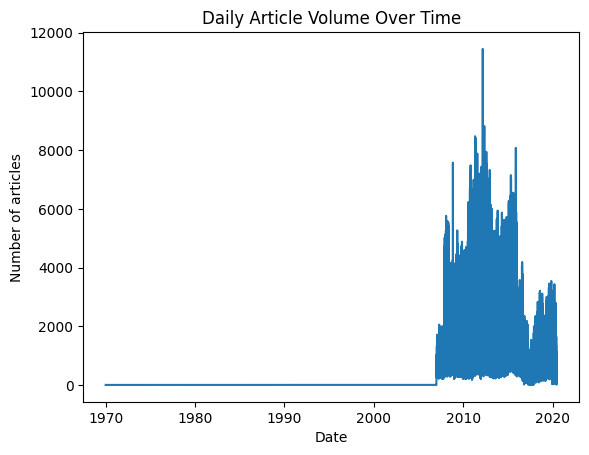

In [39]:
plt.plot(pdf_time["date_day"], pdf_time["articles_count"])
plt.xlabel("Date")
plt.ylabel("Number of articles")
plt.title("Daily Article Volume Over Time")
plt.show()

# Distribution of tickers 

In [44]:
df_ticker_count = df_final.groupBy("Stock_symbol").agg(count("*").alias("ticker_count")) \
                   .orderBy("ticker_count", ascending=False)

In [45]:
df_ticker_count_notnull = df_ticker_count.filter("Stock_symbol IS NOT NULL")

In [50]:
pdf_ticker_notnull = df_ticker_count_notnull.limit(20).toPandas()

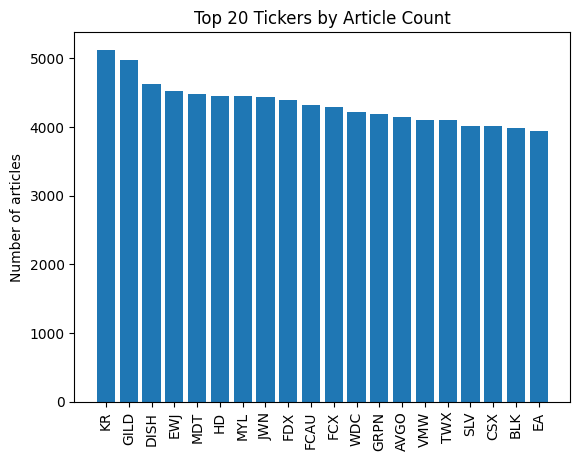

In [51]:
plt.bar(pdf_ticker_notnull["Stock_symbol"], pdf_ticker_notnull["ticker_count"])
plt.xticks(rotation=90)
plt.ylabel("Number of articles")
plt.title("Top 20 Tickers by Article Count")
plt.show()

In [56]:
df_ticker_count_asc = df_final.groupBy("Stock_symbol").agg(count("*").alias("ticker_count")) \
                   .orderBy("ticker_count", ascending=True)

In [57]:
df_ticker_count_notnull_asc = df_ticker_count_asc.filter("Stock_symbol IS NOT NULL")

In [58]:
pdf_ticker_notnull_asc = df_ticker_count_notnull_asc.limit(20).toPandas()

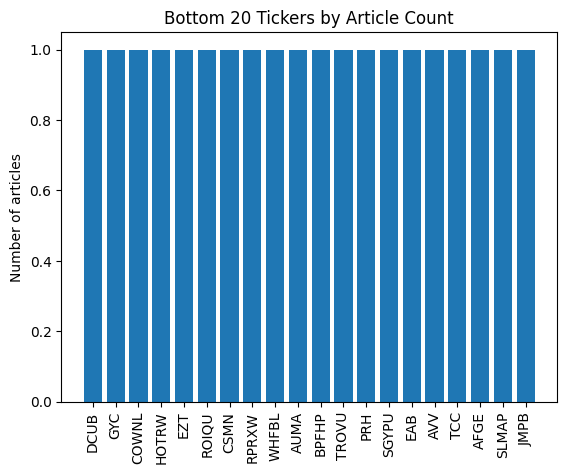

In [59]:
plt.bar(pdf_ticker_notnull_asc["Stock_symbol"], pdf_ticker_notnull_asc["ticker_count"])
plt.xticks(rotation=90)
plt.ylabel("Number of articles")
plt.title("Bottom 20 Tickers by Article Count")
plt.show()

In [61]:
df_len = df_final.withColumn("article_len", length("Article"))
# For a quick stats
df_len.describe(["article_len"]).show()

+-------+------------------+
|summary|       article_len|
+-------+------------------+
|  count|            447307|
|   mean|2784.9296366924727|
| stddev| 2676.569892247614|
|    min|                26|
|    max|             87928|
+-------+------------------+



In [67]:
pdf_len = df_len.select("article_len").sample(fraction=0.1, seed=42).toPandas()  

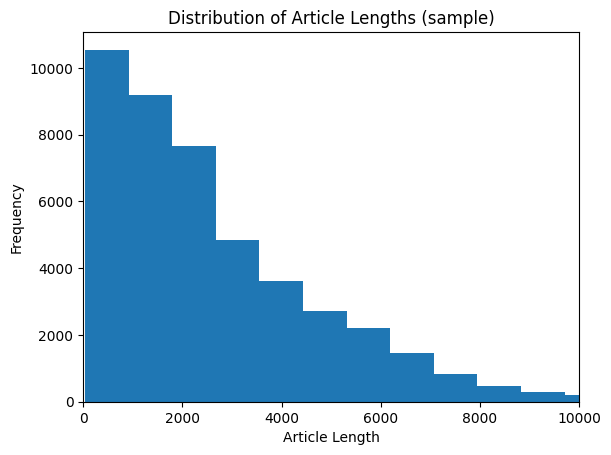

25/03/24 16:48:46 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 14983182 ms exceeds timeout 120000 ms
25/03/24 16:48:47 WARN NettyRpcEnv: Ignored message: true
25/03/24 16:48:47 WARN SparkContext: Killing executors is not supported by current scheduler.
25/03/24 16:48:47 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEn

In [69]:
# sample 10% 
plt.hist(pdf_len["article_len"], bins=100)
plt.xlabel("Article Length")
plt.ylabel("Frequency")
plt.xlim(0, 10000)
plt.title("Distribution of Article Lengths (sample)")
plt.show()

# Quick word frecuency

In [21]:
df_words = df_final.withColumn("title_lower", lower("Article_title")) \
             .withColumn("title_tokens", split("title_lower", "\\s+")) \
             .select(explode("title_tokens").alias("token"))

df_token_count = df_words.groupBy("token").count().orderBy("count", ascending=False)
df_token_count.show(50)

+----------+-------+
|     token|  count|
+----------+-------+
|        to|2844152|
|         -|2052595|
|        of|2007760|
|        in|1814985|
|       and|1608322|
|       for|1555018|
|       the|1452256|
|        on|1309777|
| announces| 648942|
|      with| 634377|
|        at| 631021|
|       new| 615642|
|       net| 570333|
|          | 563248|
|     asset| 548324|
|         a| 528126|
|  value(s)| 492053|
|       reg| 477041|
|        as| 475652|
|    update| 456075|
|   results| 455003|
|    stocks| 387096|
|  earnings| 386659|
|      from| 373110|
|      inc.| 369470|
|         &| 366737|
|    market| 354724|
|      u.s.| 347582|
|      says| 343051|
|   quarter| 341497|
|   reports| 325261|
|        by| 321581|
|    shares| 306234|
|       plc| 296278|
|     group| 294330|
|        up| 290741|
| financial| 266195|
|       etf| 259865|
|  research| 259020|
|        is| 247386|
|    global| 236389|
|     sales| 234781|
|     first| 229997|
|     stock| 226567|
|     after| 

# Date vs Ticker Heatmap

In [ ]:
df_ticker_day = df_time.groupBy("date_day", "Stock_symbol").count()

In [26]:
pdf_ticker_day = df_ticker_day.toPandas()

In [27]:
pivoted = pdf_ticker_day.pivot(index="date_day", columns="Stock_symbol", values="count").fillna(0)

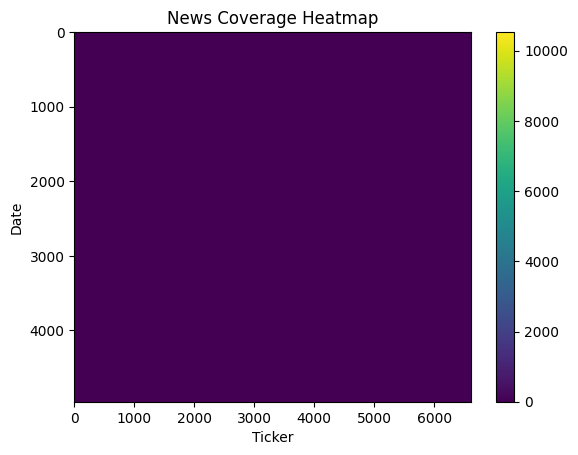

In [28]:
plt.imshow(pivoted.values, aspect='auto')
plt.xlabel("Ticker")
plt.ylabel("Date")
plt.title("News Coverage Heatmap")
plt.colorbar()
plt.show()

top 20 tickers by total coverage

In [ ]:
top_tickers = (
    df_time.groupBy("Stock_symbol")
      .agg(count("*").alias("cnt"))
      .orderBy("cnt", ascending=False)
      .limit(20)
)

In [10]:
top_ticker_list = [row["Stock_symbol"] for row in top_tickers.collect()]

In [11]:
df_sub = df_time.filter(df_time["Stock_symbol"].isin(top_ticker_list))

In [12]:
df_ticker_day_top20 = df_sub.groupBy("date_day", "Stock_symbol").count()

In [13]:
pdf_ticker_day_top = df_ticker_day_top20.toPandas()

In [15]:
pivoted_top = pdf_ticker_day_top.pivot(index="date_day", columns="Stock_symbol", values="count").fillna(0)

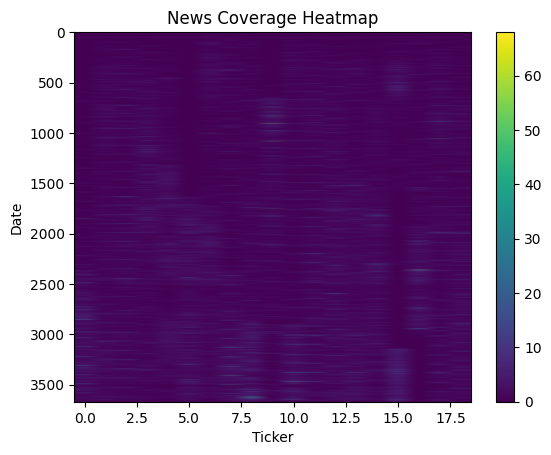

In [16]:
plt.imshow(pivoted_top.values, aspect='auto')
plt.xlabel("Ticker")
plt.ylabel("Date")
plt.title("News Coverage Heatmap")
plt.colorbar()
plt.show()

In [14]:
pivoted_top = pdf_ticker_day_top.pivot(index="date_day", columns="Stock_symbol", values="count").fillna(0)

In [7]:
df_english_only.count()

12239783

More heavier but accurate function based language detection 

In [ ]:
def detect_lang(text):
    try:
        return langdetect.detect(text)
    except:
        return "unknown"

detect_lang_udf = udf(detect_lang, StringType())

df_lang = df_csv_5gb.withColumn("detected_lang", detect_lang_udf(df_csv_5gb["Article_title"]))

df_english_only = df_lang.filter(df_lang["detected_lang"] == "en")

In [ ]:
df_english_only.write.mode("overwrite").parquet("../data/raw/english_only.parquet")